In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import v2 as transforms
import sys
from IPython.display import clear_output
%matplotlib inline

In [2]:
class Linear:
    def __init__(self, input_size, output_size):
        '''
        Creates weights and biases for linear layer.
        Dimention of inputs is *input_size*, of output: *output_size*.
        '''
        #### YOUR CODE HERE
        #### Create weights, initialize them with samples from N(0, 0.1).
        self.W = np.random.randn(input_size, output_size)*0.01
        self.b = np.zeros(output_size)

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, input_size).
        Returns output of size (N, output_size).
        Hint: You may need to store X for backward pass
        '''
        self.X = X
        return X.dot(self.W)+self.b

    def backward(self, dLdy):
        '''
        1. Compute dLdw and dLdx.
        2. Store dLdw for step() call
        3. Return dLdx
        '''
        self.dLdW = self.X.T.dot(dLdy)
        self.dLdb = dLdy.sum(0)
        self.dLdx = dLdy.dot(self.W.T)
        return self.dLdx

    def step(self, learning_rate):
        '''
        1. Apply gradient dLdw to network:
        w <- w - learning_rate*dLdw
        '''
        self.W = self.W - learning_rate * self.dLdW
        self.b = self.b - learning_rate * self.dLdb
class NLLLoss:
    def __init__(self):
        '''
        Applies Softmax operation to inputs and computes NLL loss
        '''
        pass

    def forward(self, X, y):
        '''
        Passes objects through this layer.
        X is np.array of size (N, C), where C is the number of classes
        y is np.array of size (N), contains correct labels
        '''
        self.p = np.exp(X)
        self.p /= self.p.sum(1, keepdims=True)
        self.y = np.zeros((X.shape[0], X.shape[1]))
        self.y[np.arange(X.shape[0]), y] = 1
        return -(np.log(self.p)*self.y).sum(1).mean(0)

    def backward(self):
        '''
        Note that here dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        return (self.p - self.y) / self.y.shape[0]


class NeuralNetwork:
    def __init__(self, modules):
        '''
        Constructs network with *modules* as its layers
        '''
        self.modules = modules

    def forward(self, X):
        y = X
        for i in range(len(self.modules)):
            y = self.modules[i].forward(y)
        return y

    def backward(self, dLdy):
        '''
        dLdy here is a gradient from loss function
        '''
        for i in range(len(self.modules))[::-1]:
            dLdy = self.modules[i].backward(dLdy)

    def step(self, learning_rate):
        for i in range(len(self.modules)):
            self.modules[i].step(learning_rate)


## Задание 1 (1 балл): Реализовать Tanh
Нужно реализовать функцию активации Tanh по аналогии с примерами выше

In [3]:
class Tanh:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.tanh(X)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        dydx = 1 - np.tanh(self.X)**2
        dLdx = dLdy * dydx
        return dLdx

    def step(self, learning_rate):
        pass

## Задание 2 (4 балла): Аугментации
Необходимо реализовать следующие преобразования (пример можно найти в лекции, также допускается использовать готовые варианты, например "from skimage.transform import rotate")
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности? Какие можно сделать выводы? (Сравнивать подходы можно по аналогии с тем, как это было проделано выше)

In [4]:
def MNIST_preprocessing(augmentations=[]):
    train_transforms = transforms.Compose([transforms.ToTensor()] + augmentations +
        [transforms.Normalize((0.1307,),(0.3081,))])
    test_transforms = transforms.Compose([transforms.ToTensor(),
        transforms.Normalize((0.1307,),(0.3081,))])
    train_transformed = MNIST('../hw2', train=True, transform=train_transforms, download=True)
    test_transformed = MNIST('../hw2', train=False, transform=test_transforms)
    train_loader = DataLoader(train_transformed, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_transformed, batch_size=32, shuffle=False)
    return train_loader, test_loader

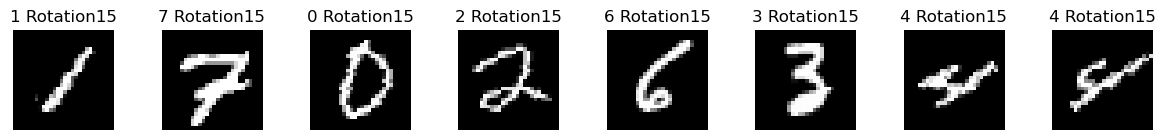

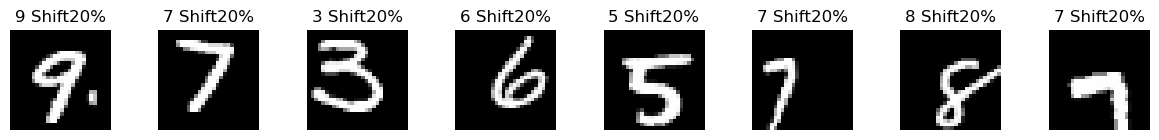

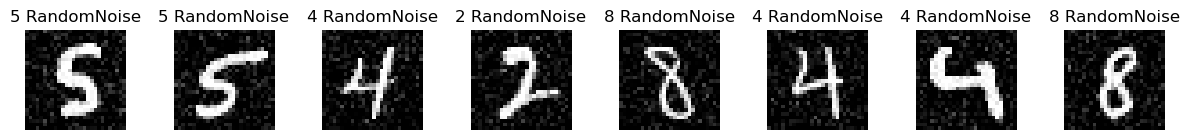

In [6]:

augmentation_tests = [[transforms.RandomAffine(degrees=15)], [transforms.RandomAffine(degrees=0, translate=(0.2, 0.2))], [transforms.GaussianNoise(mean=0.0, sigma=0.1)]]
augmentation_types = ['Rotation15', 'Shift20%', 'RandomNoise']
for i, augmentations in enumerate(augmentation_tests):
    train_loader, test_loader = MNIST_preprocessing(augmentations)
    X, y = next(iter(train_loader))
    X = X.numpy()
    y = y.numpy()
    plt.figure(figsize=(15, 6))
    for j in range(len(X)//4):
        plt.subplot(4, 8, i*(len(X)//4)+j+1)
        plt.imshow(X[j].reshape(28, 28), cmap=plt.cm.Greys_r)
        plt.title(f"{y[j]} {augmentation_types[i]}")
        plt.axis('off')
plt.show()

In [5]:
def train(network, epochs, learning_rate, augmentations=[], plot=True,
          verbose=True, loss=None):
    train_loader, test_loader = MNIST_preprocessing(augmentations)
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

сеть с активационными функциями Tanh

In [7]:
network = NeuralNetwork([
    Linear(784, 100), Tanh(), # 28 * 28
    Linear(100, 100), Tanh(),
    Linear(100, 10)
])
loss = NLLLoss()

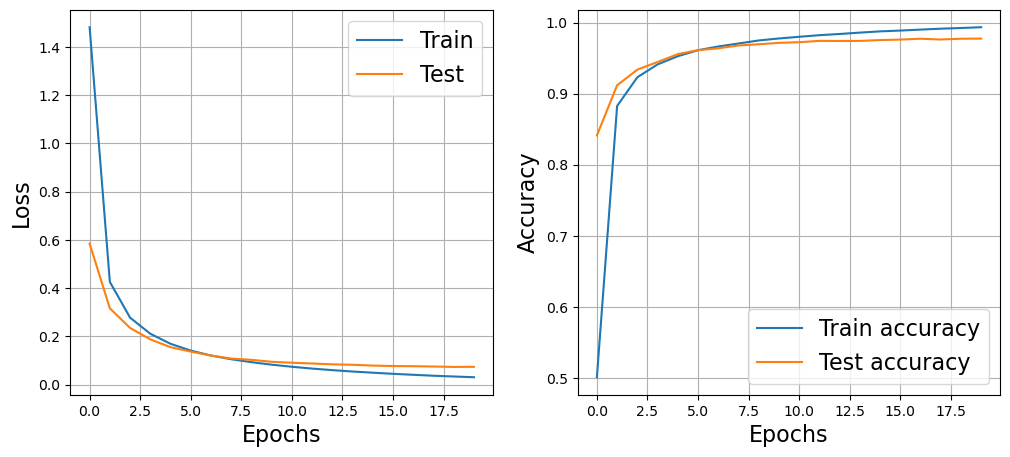

train_loss_epochs: 0.031
test_loss_epochs: 0.074
train_accuracy_epochs: 0.993
test_accuracy_epochs: 0.977


In [68]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)
print(f"""train_loss_epochs: {tr_s[-1]:.3f}
test_loss_epochs: {ts_s[-1]:.3f}
train_accuracy_epochs: {tr_ac_s[-1]:.3f}
test_accuracy_epochs: {ts_ac_s[-1]:.3f}""")

поворот

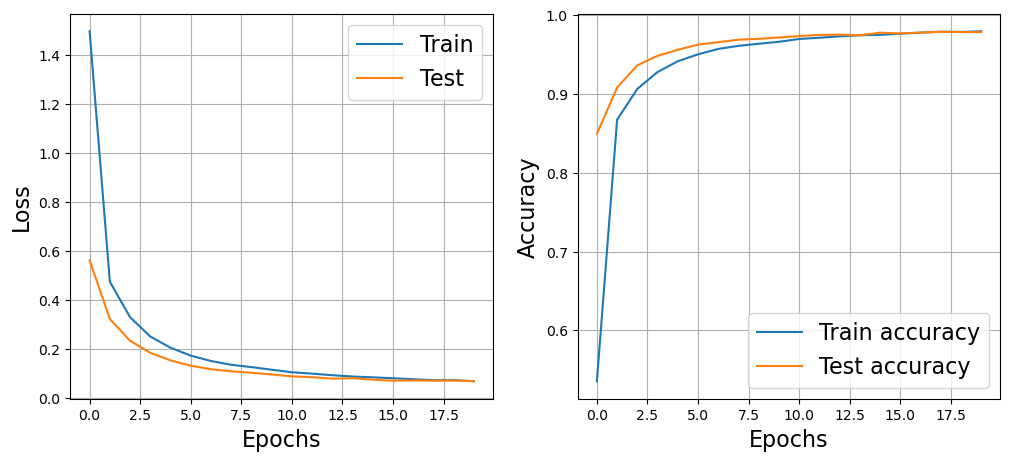

train_loss_epochs: 0.069
test_loss_epochs: 0.068
train_accuracy_epochs: 0.979
test_accuracy_epochs: 0.978


In [13]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01, [transforms.RandomAffine(degrees=15)])
print(f"""train_loss_epochs: {tr_s[-1]:.3f}
test_loss_epochs: {ts_s[-1]:.3f}
train_accuracy_epochs: {tr_ac_s[-1]:.3f}
test_accuracy_epochs: {ts_ac_s[-1]:.3f}""")

сдвиг

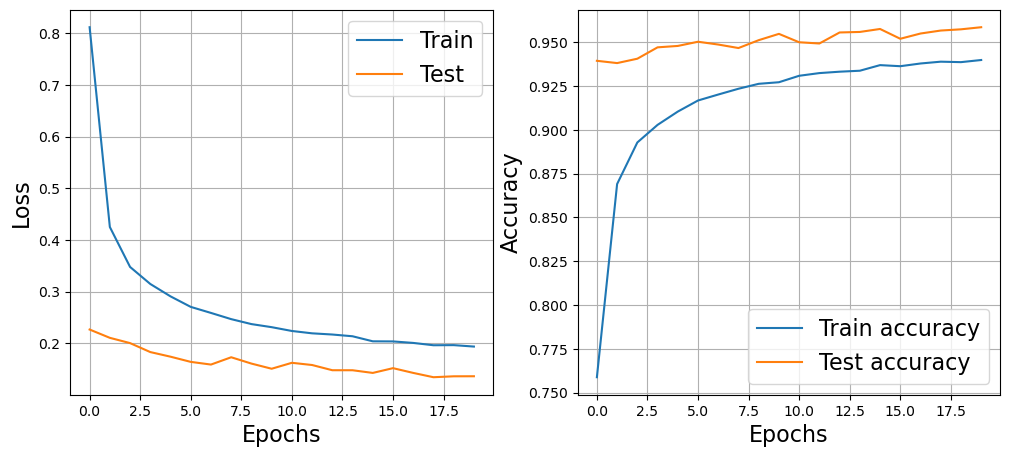

train_loss_epochs: 0.194
test_loss_epochs: 0.136
train_accuracy_epochs: 0.940
test_accuracy_epochs: 0.959


In [14]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01, [transforms.RandomAffine(degrees=0.0, translate=(0.2, 0.2))])
print(f"""train_loss_epochs: {tr_s[-1]:.3f}
test_loss_epochs: {ts_s[-1]:.3f}
train_accuracy_epochs: {tr_ac_s[-1]:.3f}
test_accuracy_epochs: {ts_ac_s[-1]:.3f}""")

шум

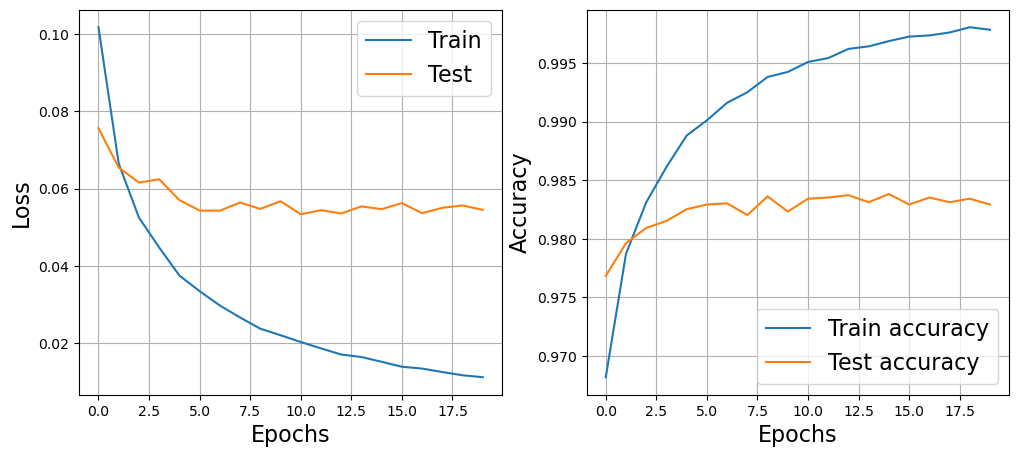

train_loss_epochs: 0.011
test_loss_epochs: 0.054
train_accuracy_epochs: 0.998
test_accuracy_epochs: 0.983


In [15]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01, [transforms.GaussianNoise(mean=0.0, sigma=0.1)])
print(f"""train_loss_epochs: {tr_s[-1]:.3f}
test_loss_epochs: {ts_s[-1]:.3f}
train_accuracy_epochs: {tr_ac_s[-1]:.3f}
test_accuracy_epochs: {ts_ac_s[-1]:.3f}""")

улучшило метрики и повысило обобщающую способность только зашумление.
поворот не изменил результат, так как в датасете уже присутствуют повернутые цифры.
а сдвиг ухудшил результат, так как на тесте цифры отцентрированы, а модель обучена распознавать сдвинутые.

шум+поворот

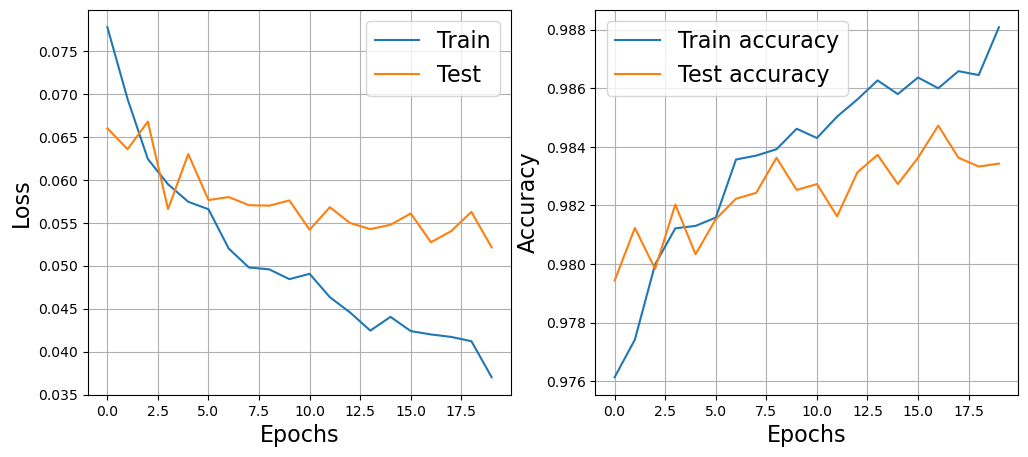

train_loss_epochs: 0.037
test_loss_epochs: 0.052
train_accuracy_epochs: 0.988
test_accuracy_epochs: 0.983


In [16]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01, [transforms.GaussianNoise(mean=0.0, sigma=0.1), transforms.RandomAffine(degrees=15)])
print(f"""train_loss_epochs: {tr_s[-1]:.3f}
test_loss_epochs: {ts_s[-1]:.3f}
train_accuracy_epochs: {tr_ac_s[-1]:.3f}
test_accuracy_epochs: {ts_ac_s[-1]:.3f}""")